# Лекция 7. LU разложение и перестановки. Устойчивость и число обусловленности.

## Что было в прошлый раз

- Закончили обсуждение алгоритмов матричного умножения
- Начали обсуждение способов решения линейных систем
- LU разложение и разложение Холецкого

## План на сегодня

- Закончить про LU разложение
- Устойчивость процедуры решения линейных систем
- Ряд Неймана и число обусловленности

## Когда алгоритм вычисления LU разложения не работает

- Что случится, если матрица не является строго регулярной (или ведущий элемент в методе Гаусса очень мал)?   

- Классический пример матрицы $2 \times 2$ с "плохим" LU разложением:

$$
    A = \begin{pmatrix}
    \varepsilon & 1 \\
    1 & 1 
    \end{pmatrix}
$$

- Если $\varepsilon$ достаточно мал, мы можем столкнуться с неустойчивостью. В то время как вычисление разложения Холецкого всегда устойчиво.

Проверим это численно...

In [7]:
import numpy as np
eps = 1.1e-16
A = np.array([[eps, 1],[1.0,  1]])

def doolittle(A):
    n = A.shape[0]
    U = np.zeros((n, n))
    L = np.eye(n)
    for i in range(n):
        U[i, i:] = A[i, i:] - L[i, :i] @ U[:i, i:]
        L[(i+1):, i] = (A[(i + 1):, i] - L[(i+1):] @ U[:, i]) / U[i, i]
    return L, U


L_d, U_d = doolittle(A)
print('L * U - A:\n', np.dot(L_d, U_d) - A)
L_d, U_d

L * U - A:
 [[ 0.00000000e+00  0.00000000e+00]
 [-1.11022302e-16  1.00000000e+00]]


(array([[1.00000000e+00, 0.00000000e+00],
        [9.09090909e+15, 1.00000000e+00]]),
 array([[ 1.10000000e-16,  1.00000000e+00],
        [ 0.00000000e+00, -9.09090909e+15]]))

## Выбор ведущего элемента (pivoting)

Мы можем переставить строки и столбцы матрицы $A$ так, чтобы элемент $A_{kk}$, на который мы делим, был максимальным.  

Простейшая, но эффективная стратегия – это выбор максимального элемента в строке: на каждом шаге выбираем элемент, который максимален по модулю и перемещаем его на диагональ.

Это даёт следующее разложение 

$$A = P L U,$$

где $P$ – это **матрица перестановки**.


- Почему это хорошая стратегия?

In [9]:
import scipy.linalg as splin

lu, p = splin.lu_factor(A)
L = np.tril(lu)
U = np.triu(lu)
np_piv = [1, 0]
print(p, "\n", L, "\n", U )
print((L @ U)[np_piv, :] - A)
I_guess = splin.lu_solve((lu, p), A)
print(I_guess)

[1 1] 
 [[1.0e+00 0.0e+00]
 [1.1e-16 1.0e+00]] 
 [[1. 1.]
 [0. 1.]]
[[ 0.00000000e+00 -1.11022302e-16]
 [ 0.00000000e+00  0.00000000e+00]]
[[1. 0.]
 [0. 1.]]


## Устойчивость линейных систем

- Существует фундаментальная проблема с решением систем линейных уравнений, которая не зависит от используемого алгоритма.

- Она проявляется, когда элементы матрицы представляются как числа с плавающей точкой или имеется некоторый шум в измерениях.

Проиллюстрируем эту проблему на следующем примере.

1.140379348493522


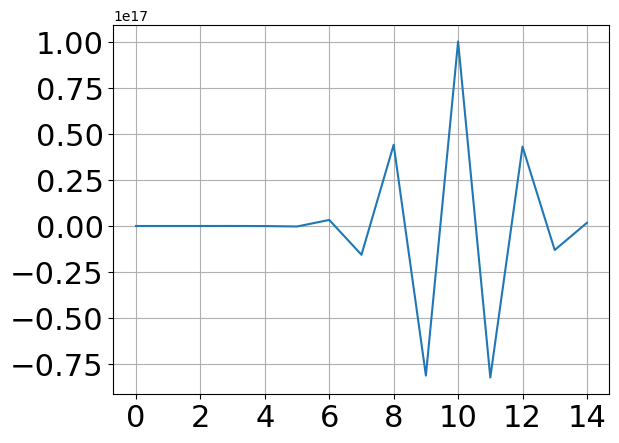

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
n = 15
a = [[1.0/(i + j + 1) for i in range(n)] for j in range(n)]
a = np.array(a)
rhs = np.random.randn(n) #Right-hand side
x = np.linalg.solve(a, rhs) #This function computes LU-factorization and solves linear system

#And check if everything is fine
er = np.linalg.norm(a.dot(x) - rhs) / np.linalg.norm(rhs)
print(er)
plt.plot(x)
plt.grid(True)
plt.xticks(fontsize=22)
_ = plt.yticks(fontsize=22)

## Ряд Неймана

Для того чтобы выяснить, почему в решении была такая большая ошибка, нам потребуется важный вспомогательный результат.  

**Ряд Неймана**:  

Если матрица $F$ такая что $\Vert F \Vert < 1$, тогда матрица $(I - F)$ обратима и

$$(I - F)^{-1} = I + F + F^2 + F^3 + \ldots = \sum_{k=0}^{\infty} F^k.$$

Заметим, что это матричная версия выражения для суммы геометрической прогрессии. 

## Доказательство

Сначала докажем, что ряд $\sum_{k=0}^{\infty} F^k$ сходится.  

Как и в скалярном случае выполнено

$$
   (I - F) \sum_{k=0}^N F^k = (I - F^{N+1}) \rightarrow I, \quad N \to +\infty
$$

Действительно,

$$
\| (I - F^{N+1}) - I\| = \|F^{N+1}\| \leqslant \|F\|^{N+1} \to 0, \quad N\to +\infty.
$$

Также можем оценить **норму обратной матрицы**:

$$
  \|(I - F)^{-1} \| = \left\Vert \sum_{k=0}^N F^k \right\Vert \leq \sum_{k=0}^N \Vert F \Vert^k \Vert I \Vert \leq \frac{\Vert I \Vert}{1 - \Vert F \Vert} 
$$

## Малое возмущение обратной матрицы

Используя этот результат, мы можем оценить как возмущение в элементах матрицы влияет на возмущение в элементах обратной матрицы. Предположим, что возмущение $E$ мало в том смысле, что $\Vert A^{-1} E \Vert < 1$. Тогда

$$(A + E)^{-1} = (A(I + A^{-1}E))^{-1} = (I + A^{-1}E)^{-1}A^{-1} = \sum_{k=0}^{\infty} (-A^{-1} E)^k A^{-1}$$

и

$$
  \frac{\Vert (A + E)^{-1} - A^{-1} \Vert}{\Vert A^{-1} \Vert} \leq \frac{\Vert A^{-1} E \Vert}{1 - \Vert A^{-1} E \Vert} \leq \frac{\Vert A^{-1} \Vert \Vert E \Vert}{1 - \Vert A^{-1} E \Vert}.
$$

Видно, что норма обратной матрицы входит в оценку.

## Число обусловленности линейной системы

Рассмотрим **возмущённую** линейную систему:

$$
   (A + \Delta A) (x + \Delta x) = f + \Delta f \quad \text{или} \quad (A + \Delta A)\Delta x = -\Delta A x + \Delta f
$$

такую что 

- $\| \Delta A \| \leq \epsilon \| A \|$ и $\| \Delta f \| \leq \epsilon \| f \|$
- Также $\epsilon \| A \| \| A^{-1} \| < 1$

## Оценки!

$$
\begin{split}
\Delta x &= (A + \Delta A)^{-1} (\Delta f - \Delta A x) =\\ 
&= \left(A(I + A^{-1}\Delta A)\right)^{-1}(\Delta f - \Delta A x) = \\
& = (I + A^{-1}\Delta A)^{-1} A^{-1} (\Delta f - \Delta A x) \\
\end{split}
$$

Далее оценим относительную ошибку
$$
\begin{split}
\frac{\| \Delta x \|}{\| x \|}& = \| (I + A^{-1}\Delta A)^{-1} \| \| A^{-1} \| \left( \frac{\| \Delta f \|}{\| x \|} + \frac{\| \Delta A x \|}{\| x \|} \right) \\
& = \| (I + A^{-1}\Delta A)^{-1} \| \| A^{-1} \| \left( \frac{\| \Delta f \|}{\| x \|} + \| \Delta A \| \right) \\
\end{split}
$$

Подробнее распишем первый множитель

$$\| (I + A^{-1}\Delta A)^{-1} \| \leq \sum_{k=0}^{\infty}\| A^{-1}\Delta A \|^k, $$

где $\| A^{-1}\Delta A \| \leq \| A^{-1}\| \| \Delta A \| \leq \epsilon \| A^{-1}\| \| A \| < 1$.

В этом случае

 $$ \| (I + A^{-1}\Delta A)^{-1} \| \leq \sum_{k=0}^{\infty}\| A^{-1}\|^k \|\Delta A \|^k = \frac{1}{1 - \| A^{-1}\| \|\Delta A \|}.$$
 
Тогда выражение для относительной ошибки примет вид

$$ \frac{\| \Delta x \|}{\| x \|} = \frac{1}{1 - \| A^{-1}\| \|\Delta A \|}\| A^{-1} \| \left( \frac{\| \Delta f \|}{\| x \|} + \| \Delta A \| \right) = \frac{\|A\| \|A^{-1}\}}{1 - \|A\| \|A^{-1}\| \frac{\|\Delta A \|}{\|A\|}} \left( \frac{\| \Delta f \|}{\|A\| \| x \|} + \frac{\| \Delta A \|}{\|A\|} \right) \leq \frac{\mathrm{cond}(A)}{1 - \mathrm{cond}(A) \frac{\|\Delta A \|}{\|A\|}} \left( \frac{\| \Delta f \|}{\|f\|} + \frac{\| \Delta A \|}{\|A\|} \right) $$

так как $ \|f \| = \|Ax\| \leq \|A\| \|x\|$

Главную роль играет **число обусловленности** матрицы $A$: $\mathrm{cond}(A) = \Vert A \Vert \Vert A^{-1} \Vert$.

## Число обусловленности

- Чем больше число обусловленности, тем меньше цифр в записи числа мы можем правильно восстановить. 
- Число обусловленности разное для разных норм.
- Для спектральной нормы выполнено (проверьте!) $\mathrm{cond}_2 (A) = \|A\|_2 \|A^{-1}\|_2 = \frac{\sigma_{\max}(A)}{\sigma_{\min}(A)}$
- Заметим, что если $\Delta A = 0$, тогда

$$
\frac{\Vert \widehat{x} - x \Vert}{\Vert x \Vert} \leq \mathrm{cond}(A) \frac{\|\Delta f\|}{\|f\|}
$$

## И снова матрица Гильберта 

- Проверим насколько оценка точная в двух случаях: единичная правая часть и случайная правая часть
- Результаты существенно отличаются!

Error: 1.1945765847336888e-07 Condition number: 2.7714433370477366e+20


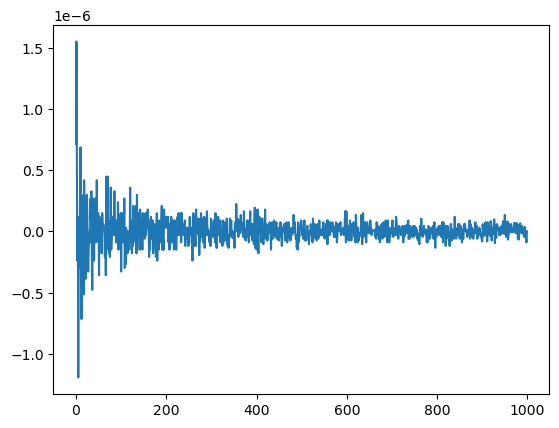

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


n = 1000
a = [[1.0/(i + j + 1) for i in range(n)] for j in range(n)]
a = np.array(a)
rhs = np.ones(n) #Right-hand side
f = np.linalg.solve(a, rhs)

#And check if everything is fine
er = np.linalg.norm(a.dot(f) - rhs) / np.linalg.norm(rhs)
cn = np.linalg.cond(a, 2)
print('Error:', er, 'Condition number:', cn)
plt.plot(a.dot(f) - rhs)

Error: 0.881185876200993 Condition number: 2.3228053763031325e+17


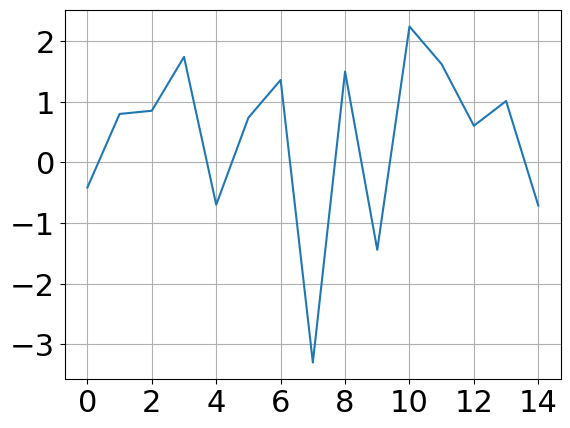

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n = 15
a = [[1.0/(i + j + 1) for i in range(n)] for j in range(n)]
a = np.array(a)
rhs = np.random.randn(n) #Right-hand side
f = np.linalg.solve(a, rhs)

#And check if everything is fine
er = np.linalg.norm(a.dot(f) - rhs) / np.linalg.norm(rhs)
cn = np.linalg.cond(a)
print('Error:', er, 'Condition number:', cn)

u, s, v = np.linalg.svd(a)
rhs = np.random.randn(n)
plt.plot(a.dot(f) - rhs)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.grid(True)

### Как это объяснить?

## Выводы

- Перестановки расширяют область применения LU разложения
- Сложность в общем случае $O(n^3)$
- Ряд Неймана
- Для оценки устойчивости используется число обусловленности